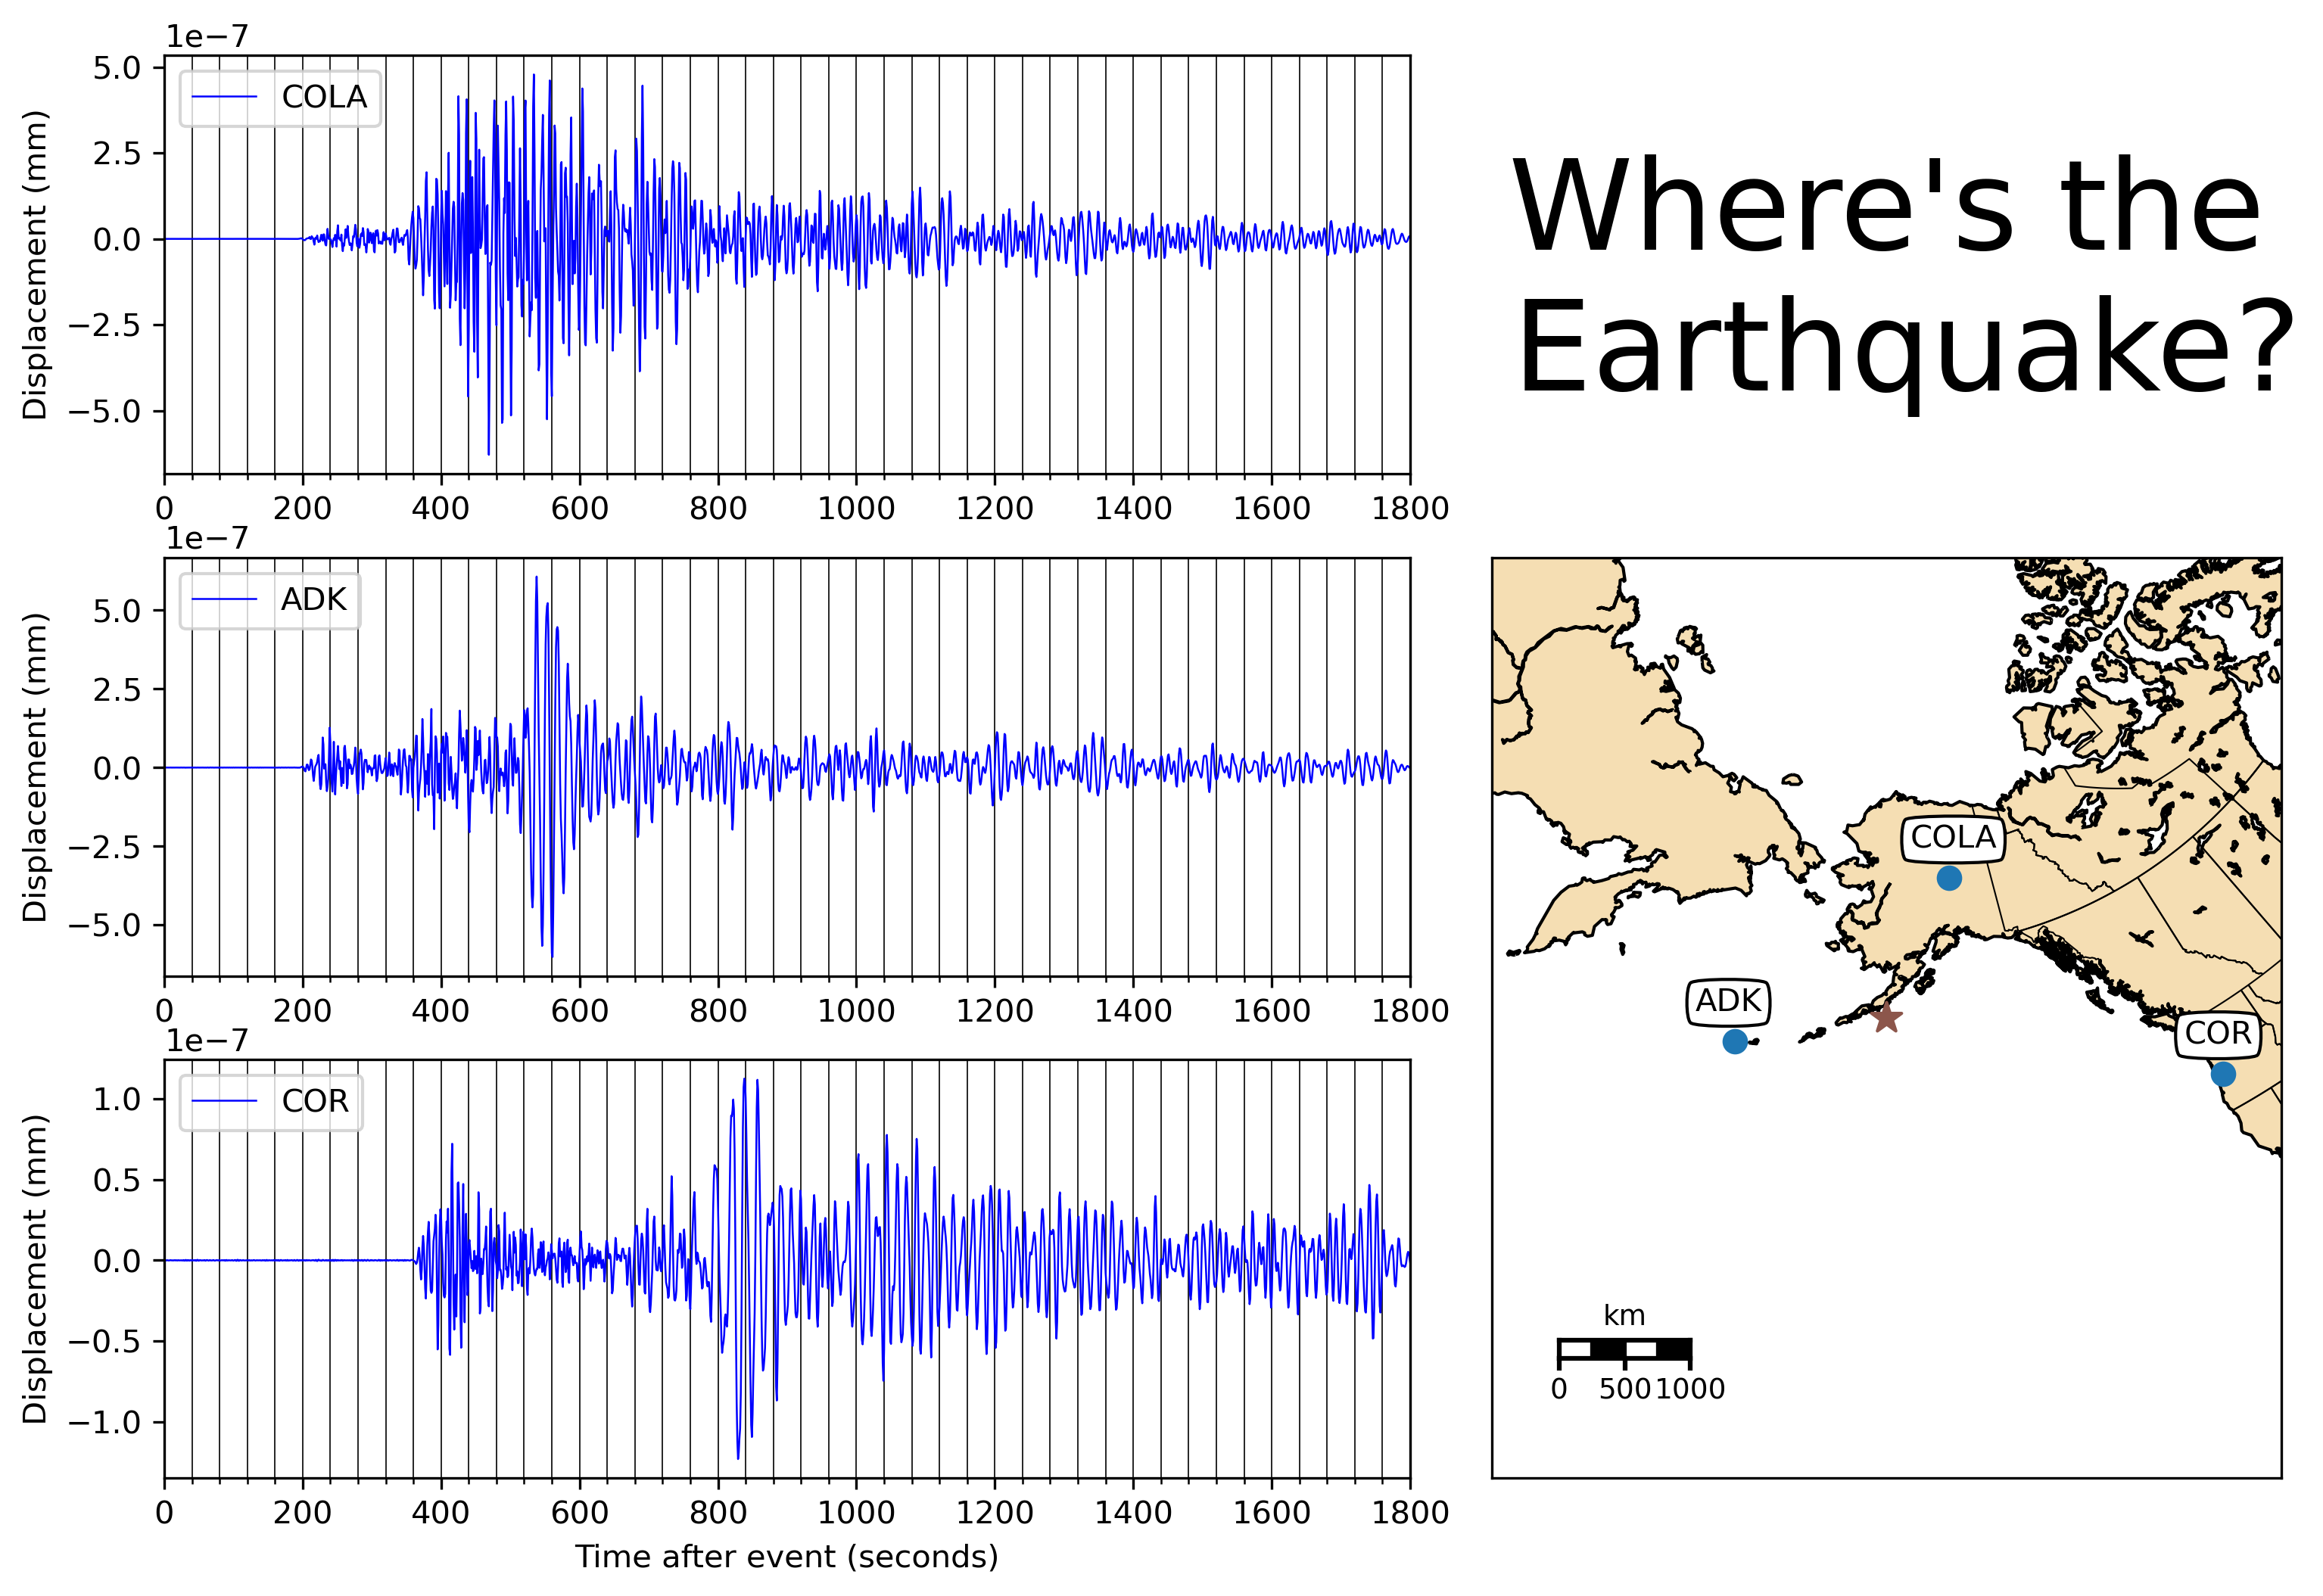

In [32]:
from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.basemap import Basemap
import numpy as np
import random


# Station map location: http://ds.iris.edu/gmap

## Earthquake event information ##

ev_time="2020-07-22T06:12:00.000"
ev_mag = 6.0

ev_lat = 55.072
ev_lon = -158.596

filename="Alaska"

# Show Earthquake location True or False
show = True
make_files= True

## Station Information ##
CLIENT = "IRIS"
NETWORK= ['IU', 'IU', 'IU']
STATION = ["COLA","ADK","COR"]
LOC_CODE = ["00", "00", "00"]
CHANNEL = ['LHZ', "LHZ", "LHZ"]

client = Client(CLIENT)
# click on the meta data aggregator: http://ds.iris.edu/mda/?datacenter=IRISDMC
# look for stations and channels with a green A next it as these are freely available

## Plotting properties ##
count = len(STATION)
lon = []
lat = []

    # Setting up the figure size for A4 
    # https://matplotlib.org/stable/tutorials/intermediate/arranging_axes.html
fig = plt.figure(figsize=(11.7,8.3), dpi=300)
    # SPlitting the page into grids to help with plotting
spec = fig.add_gridspec(nrows=count, ncols=5, left= 0.1)

## Processing properties ##
    # Pre filtering to avoid problems during the deconvolution
pre_filt = (0.0001, 0.0005, 0.9, 0.91)
low_filt = 0.1
high_filt = 0.40
    #Converts time to UTC date time format for processing
ev_start = UTCDateTime(ev_time)
trim_value = 5
trim_start = ev_start - trim_value
trim_end = ev_start + 30*60 + trim_value

## Waveform gathering and plotting ##

for i in range(count):

    st = client.get_waveforms(NETWORK[i], STATION[i], LOC_CODE[i], CHANNEL[i], trim_start, trim_end, attach_response=True)
    inv= client.get_stations(network=NETWORK[i], sta=STATION[i],loc=LOC_CODE[i], channel=CHANNEL[i])

    lon.append(inv.networks[0].stations[0].longitude)
    lat.append(inv.networks[0].stations[0].latitude)

    st = st.remove_response(pre_filt=pre_filt, output='DISP')

    st.filter('bandpass', freqmin=low_filt, freqmax=high_filt, corners=2, zerophase=True)
    st.trim(starttime=trim_start + trim_value, endtime=trim_end - trim_value)
    st = st[0]

    ## Waveform plotting ##
    ax = fig.add_subplot(spec[i,0:3])
    # Sets the waveform to the grid row i , and the first column to the third

    ax.plot(st.times("relative"), st.data/1000, color="blue", linewidth=0.6, label=STATION[i])
    # Plots the relative time from the start time (x value), with the waveform info (y axis)
    # in color (American spelling) black ("k") 
    ax.legend(loc="upper left")
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_ylabel("Displacement (mm)")
    # Sets minor ticks between major ticks, splitting it to 5, in this case 20s
    if i == (count-1):
        ax.set_xlabel("Time after event (seconds)")
    ax.tick_params(which="minor")
    ax.xaxis.grid(which="both", color="k",linewidth=0.4)
    ax.set_axisbelow(True)
    x_lim = st.times("relative")[-1]
    plt.xlim(0,x_lim)

ax.tick_params(which="minor")
ax.xaxis.grid(which="both", color="k",linewidth=0.4)
ax.set_axisbelow(True)

## Basemap location ##
axm= fig.add_subplot(spec[-2:,3:])


j = random.randint(-4,4)
k = random.randint(-2,2)
m = Basemap(width=6000000,height=7000000, resolution='l',projection='lcc',
            lat_1=ev_lat-20.,lat_2=ev_lat+20,lon_0=ev_lon,lat_0=ev_lat, ax=axm)
#m = Basemap(width=6000000,height=6000000,
#            resolution='l',projection='stere',lat_ts=ev_lat,lat_0=ev_lat,lon_0=ev_lon)

#m = Basemap(width=6000000,height=6000000,projection='cea',llcrnrlat=20,urcrnrlat=80,\
#            llcrnrlon=-180,urcrnrlon=-120,resolution='c')

m.drawcoastlines()
m.fillcontinents(color="wheat")
m.drawcountries()
m.drawstates()
#m.drawparallels(np.arange(20,80,10),labels=[1,1,0,0])
#m.drawmeridians(np.arange(-180,0,10),labels=[0,0,0,1])


x, y = m(lon,lat)
m.scatter(x,y, 50, marker="o", zorder=4)

bbox_props = dict(boxstyle="Round4,pad=0.3", fc="white")
for i in range(count):
    axm.text(x[i]-3e5,y[i]+23e4,STATION[i],zorder=5, bbox=bbox_props)
m.drawmapscale(ev_lon-20+j,ev_lat-25+k,ev_lon-25+j,ev_lat-25+k,1000,barstyle="fancy")

## Title ##

axt = fig.add_subplot(spec[0,3:4])

axt.text(1.1,0.2,"Where's the\n Earthquake?",fontsize=40, ha="center")
axt.axis("off")

if make_files == True:
    fig.savefig(filename+"_Student.png", dpi="figure",bbox_inches="tight", facecolor="white")

## Earthquake Plot ##
if show == True:
    xe, ye = m(ev_lon, ev_lat)
    m.scatter(xe,ye,100,marker="*", zorder=6)
    if make_files == True:
        fig.savefig(filename+"_Teacher.png", dpi="figure",bbox_inches="tight", facecolor="white")


plt.show()